In [1]:
import sys
import os

import torch
from PIL import Image
from torchvision import transforms as T
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange
import matplotlib.pyplot as plt

sys.path.append("../")
from CLIP.clip import load, tokenize
from CLIP.clip.simple_tokenizer import SimpleTokenizer

In [2]:
device = torch.device("cpu")

In [3]:
clip_model, transform = load("ViT-B/32", jit=False, device=device)
clip_model = clip_model.eval().float()

In [4]:
clip_tokenizer = SimpleTokenizer()

In [5]:
def decode_text(model, embedding):
    # from embed weights to tokens
    embed_weights = model.token_embedding.weight.data
    if embedding.ndim > 2:
        embedding = embedding.squeeze(0)
    decoded_tokens = np.array([torch.argmin(torch.norm(embed_weights - e, dim=-1)).item() for e in embedding])
    decoded_tokens = decoded_tokens[decoded_tokens != 0][1:-1] # ignore empty stops, start, and end token
    decoded_text = tokenizer.decode(decoded_tokens)
    return decoded_text

['Autumn_1875_Frederic_Edwin_Church.jpg', 'ouzi.jpg', '.ipynb_checkpoints', 'anton_climb.jpg', 'hot-dog.jpg']


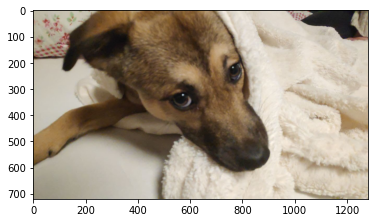

In [6]:
# load image
base_images = os.listdir("base_images")
print(base_images)
img_name = base_images[1]
img = Image.open("base_images/" + img_name).convert("RGB")
norm = transform.transforms[-1]

norm_img = norm(T.ToTensor()(img.resize((224, 224)))).unsqueeze(0).to(device)
with torch.no_grad():
    norm_img_feats = clip_model.encode_image(norm_img)

plt.imshow(img)

In [10]:
tens = T.ToTensor()(img.resize((224, 224)))

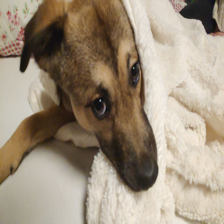

In [11]:
T.ToPILImage()(tens)

In [25]:
import torchvision
import random
seed = np.random.randint(2147483647) # make a seed with numpy generator 
random.seed(seed) # apply this seed to img tranfsorms
torch.manual_seed(seed) # needed for torchvision 0.7
torch.cuda.manual_seed(seed)
crop = torchvision.transforms.RandomResizedCrop(256, scale=(0.5, 1.0), ratio=(0.75, 1.3333333333333333))

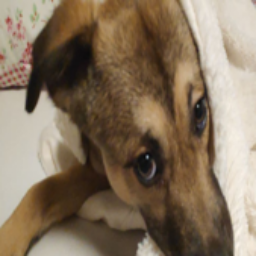

In [27]:
random.seed(seed) # apply this seed to img tranfsorms
torch.manual_seed(seed) # needed for torchvision 0.7
torch.cuda.manual_seed(seed)
T.ToPILImage()(crop(tens))

In [7]:
# create start text
start_token = 1
text = "A picture of a cat."
tokens = tokenize(text)
print(tokens)

embed = clip_model.embed_text(tokens.to(device)).detach()
embed_std = embed.std()
embed_mean = embed.mean()

max_idx = tokens.argmax()
opt = embed[0, start_token: max_idx].clone().detach().requires_grad_(True)
opt_norm = opt.detach().norm(dim=-1).mean().item()
opt_mean = opt.detach().mean(dim=-1).mean().item()
opt_std = opt.detach().std(dim=-1).mean().item()

embed[0, start_token: max_idx] = 0
print(opt.shape)

tensor([[49406,   320,  1674,   539,   320,  2368,   269, 49407,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]])
torch.Size([6, 512])


In [8]:
t = T.Compose([#T.Resize((224, 224)),
               T.RandomResizedCrop(224, scale=(0.6, 1.0), ratio=(0.9, 1.1)),
               
    
               #T.RandomAffine([0, 10], 
               #     translate=(0, 0.3),
               #     scale=(0.8, 1.0), 
               #     shear=(0.5, 0.8),
               #     fillcolor=255),
              #T.RandomGrayscale(p=0.2),
              #T.RandomPerspective(distortion_scale=0.3,
              #                    p=0.3,
              #                    fill=255),
               T.ToTensor(),
               norm,
            ])

# demonstrate transform
#T.ToPILImage()(t(img))


In [9]:
prefix = embed[0, :start_token]
suffix = embed[0, max_idx:]

In [10]:
import random 
def augment_text(opt, prefix, suffix, n_gram=1):
    pos = random.randint(0, len(opt) - n_gram)

    opt_part = opt[pos: pos + n_gram]

    new_emb = torch.cat([prefix, opt_part, suffix,])
    size = n_gram + len(prefix) + len(suffix)
    if size < 77:
        new_emb = torch.cat([new_emb, torch.stack([suffix[-1].clone() for _ in range(77 - size)])])
        
    return new_emb

In [11]:
lr = 0.01
steps = 100
bs = 16


optimizer = torch.optim.Adam([opt], lr=lr)#, weight_decay=0.2)


best_text = None
best_text_loss = 100
aug_losses = []
losses = []
text_losses = []
reg_losses = []

embed_weights = model.token_embedding.weight.data


pbar = trange(steps)
for step in range(steps):
    embedding = embed.clone()
    embedding[0, start_token:max_idx] += opt
    
    # optimize only full text
    embedding_batch = augment_text(opt, prefix, suffix, n_gram=len(opt)).unsqueeze(0)
    # optimize random n_grams
    #embedding_batch = torch.stack([augment_text(opt, prefix, suffix, n_gram=random.randint(1, len(opt))) for _ in range(bs)])
    # only optimize single tokens
    #embedding_batch = torch.stack([augment_text(opt, prefix, suffix, n_gram=1) for _ in range(bs)])
    
    #embedding_batch = torch.cat([embedding + torch.zeros_like(embedding).normal_(mean=0, std=embed_std.item() / 10) for _ in range(bs)])
    text_feats = model.encode_text(tokens, embedding=embedding_batch).to(device)
    
    # get img feats
    #img_batch = t(img).unsqueeze(0)
    img_batch = torch.stack([t(img) for _ in range(bs)])
    with torch.no_grad():
        img_feats = model.encode_image(img_batch.to(device))
        
    norm_loss = (opt.norm(dim=-1).mean() - opt_norm) ** 2
    mean_loss = (opt.mean(dim=-1).mean() - opt_mean) ** 2
    std_loss = (opt.std(dim=-1).mean() - opt_std) ** 2
    #reg_loss = norm_loss + mean_loss + std_loss
    #reg_loss = torch.mean(torch.stack([(o - embed_weights).mean() for o in opt]))
    reg_loss = torch.topk(torch.stack([torch.norm(o - embed_weights, dim=-1, p=3) for o in opt]), 1, largest=False).values.mean() * 0.02

    reg_losses.append(reg_loss.item())
    sim_loss = -1 * (torch.nn.functional.cosine_similarity(text_feats, img_feats)).mean()
    
    loss = sim_loss + reg_loss
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    # move opt back to orig stats - does not work
    #with torch.no_grad():
    #    opt = (opt - opt.mean(dim=-1, keepdim=True)) / opt.std(dim=-1, keepdim=True)
    #    opt = (opt * opt_std) + opt_mean
    
    # calc non-augmented loss
    with torch.no_grad():
        non_aug_text_feats = model.encode_text(tokens, embedding=embedding)
    non_aug_loss = -1 * (torch.nn.functional.cosine_similarity(non_aug_text_feats, norm_img_feats)).mean()
    # log losses
    aug_losses.append(sim_loss.item())
    losses.append(non_aug_loss.item())
    # decode text
    current_text = decode_text(model, embedding)
    # calc loss based on decoded text
    decode_loss = -1 * (torch.nn.functional.cosine_similarity(model.encode_text(tokenize(current_text).to(device)), norm_img_feats)).item()
    text_losses.append(decode_loss)
    
    if decode_loss < best_text_loss:
        best_text = current_text
        best_text_loss = decode_loss
    
    pbar.update(1)
    pbar.set_description(current_text + " - aug loss " + str(round(loss.item(), 2)) + " loss " + str(round(non_aug_loss.item(), 2)) + " decode loss " + str(round(decode_loss, 2)))

NameError: name 'model' is not defined

In [60]:
#p = plt.hist(opt[0].cpu().detach().flatten().numpy(), bins=100)

In [61]:
reg_loss = torch.topk(torch.stack([torch.norm(o - embed_weights, dim=-1, p=3) for o in opt]), 1, largest=False).values.mean()
reg_loss

tensor(0.7410, device='cuda:0', grad_fn=<MeanBackward0>)

In [62]:
#'ó charismatic herr sunsetgrayson' - for me
#'" landscapes voyage schelthur' - for autumn
#'patient �📝: rito grows ' - for ouzi
#'roomie stru<|startoftext|>saharan collie ' for ouzi
#'photoshopped yikes .- hotdog watches ' - for hot-dog

In [63]:
best_text

'admits picture of - dog kangaroo '

In [64]:
torch.nn.functional.cosine_similarity(model.encode_text(tokenize(best_text).to(device)), norm_img_feats).item()

0.2753150165081024

In [227]:
torch.nn.functional.cosine_similarity(clip_model.encode_text(tokenize("A picture of a dog in a blanket").to(device)), norm_img_feats).item()

0.3062761723995209

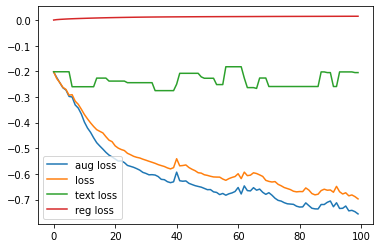

In [66]:
plt.plot(aug_losses, label="aug loss")
plt.plot(losses, label="loss")
plt.plot(text_losses, label="text loss")
plt.plot(reg_losses, label="reg loss")
plt.legend()

In [67]:
decode_text(model, embedding)

'fchadith nantes - momma asbestos '

In [20]:
from tqdm.notebook import tqdm

In [ ]:
#token_losses = []

#ds = torch.utils.data.TensorDataset(embed_weights)
#dl = torch.utils.data.DataLoader(ds, batch_size=64)

all_text_feats = []

embed_weights = model.token_embedding.weight.data


for token_emb in tqdm(embed_weights):    
    embedding = embed.clone()
    embedding[0, start_token:max_idx] += token_emb.unsqueeze(0)
    
    with torch.no_grad():
        text_feats = model.encode_text(tokens, embedding=embedding)
        
    all_text_feats.append(text_feats)
    
    #loss = -1 * (torch.nn.functional.cosine_similarity(text_feats, norm_img_feats)).detach()
    #token_losses.append(loss)
    

In [ ]:
feats = torch.stack(all_text_feats).squeeze()

In [ ]:
#torch.save(feats.cpu(), "feats.pt")
#feats = torch.load("feats.pt")

In [ ]:
losses = torch.nn.functional.cosine_similarity(feats, norm_img_feats)

In [ ]:
#decode_text(model, feats[torch.argmax(losses).unsqueeze(0)])

In [ ]:
k = 200
best_tokens = torch.topk(losses, k).indices.cpu().numpy()
decoded_text = tokenizer.decode(best_tokens)
print(torch.topk(losses, k).values.cpu().numpy())
print(decoded_text)

In [ ]:
opt.shape

In [ ]:
embedding.shape

In [ ]:
embed_weights.shape

In [ ]:
model.encode_text(tokens, embedding=embed_weights[0].unsqueeze(0))

In [106]:
from transformers import GPTNeoForCausalLM, GPT2Tokenizer
model = GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-1.3B")
tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")

In [ ]:
from transformers import GPTNeoForCausalLM, GPT2Tokenizer
model = GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-2.7B")
tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-2.7B")

Downloading:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.7G [00:00<?, ?B/s]

In [ ]:
input_ids = tokenizer("Let me tell you something about this girl named Emilia Wiehe.", return_tensors="pt").input_ids

In [ ]:
gen_tokens = model.generate(input_ids, do_sample=True, temperature=0.9, max_length=100,)

In [ ]:
gen_text = tokenizer.batch_decode(gen_tokens)[0]

In [ ]:
gen_text

In [ ]:
gen_text

In [ ]:
gen_tokens = model.generate(past_key_values=torch.zeros(5, 2048), do_sample=True, temperature=0.9, max_length=100, use_cache=True)

In [ ]:
gen_text = tokenizer.batch_decode(gen_tokens)[0]

In [ ]:
gen_text

In [ ]:
gen_tokens

In [97]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
from tqdm.notebook import tqdm

device = torch.device("cpu")

tokenizer = GPT2Tokenizer.from_pretrained("gpt2-large")
model = GPT2LMHeadModel.from_pretrained('gpt2-large').to(device)

In [107]:
prompt_1 = """
The following are adjectives describing a song, followed by a description of the corresponding music video.
Song description: fast, guitar, sad. Corresponding video description: A biker plays the guitar while crying.
Song description: loud, techno, electronic. Corresponding video description: Dynamic and vibrant colours form geometric shapes.
Song description: slow, piano, solo. Corresponding video description:"""
prompt_2 = """
Song description: fast, guitar, sad. Corresponding video description: A biker plays the guitar while crying.
Song description: loud, techno, electronic. Corresponding video description: Dynamic and vibrant colours form geometric shapes.
Song description: slow, piano, solo. Corresponding video description:"""
prompt_3 = """The following are adjectives describing a song, followed by a description of a corresponding image:
Song description: fast, guitar, sad. Corresponding image description: A biker plays the guitar while crying.
Song description: loud, techno, electronic. Corresponding image description: Dynamic and vibrant colours form geometric shapes.
Song description: slow, piano, solo. Corresponding image description:"""

out = model.generate(tokenizer.encode(prompt_3, return_tensors="pt").to(device),
                     top_p=0.95, do_sample=True, output_scores=True, 
                     past_key_values=None,#past, 
                     return_dict_in_generate=True, 
                     max_length=100)
out_text = tokenizer.decode(out["sequences"].tolist()[0])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
#gpt2 prompt3

In [105]:
out_text.split("Corresponding image description:")[3].split("\n")[0].strip()

"The words'shuffle' and 'beat' merge in the middle of the melody."

In [103]:
out_text.split("Corresponding image description:")[3].split("\n")[0].strip()

'A piano plays as a soloist dances.'

In [99]:
out_text.split("Corresponding image description:")[3].split("\n")[0].strip()

'A lone piano sits in a window frame.'

In [101]:
out_text.split("Corresponding image description:")[3].split("\n")[0].strip()

'Lines dance around each other in a circle.<|endoftext|>'

In [ ]:
# gpt neo prompt 3

In [108]:
out_text.split("Corresponding image description:")[3].split("\n")[0].strip()

'A woman sits quietly in the kitchen, looking at the window.'

In [96]:
out_text.split("Corresponding image description:")[3].split("\n")[0].strip()

"A man's arms are holding the keys of a piano while looking out the window in a beautiful city"

In [93]:
out_text.split("Corresponding image description:")[3].split("\n")[0].strip()

'A lonely musician, alone in a dark room.'

In [91]:
out_text.split("Corresponding image description:")[3].split("\n")[0].strip()

'A woman sits alone. The song is a slow, piano composition.'

In [89]:
out_text.split("Corresponding image description:")[3].split("\n")[0].strip()

'The image contains a slow rhythm, which is similar to the music in the song.'

In [79]:
out_text.split("Corresponding video description:")[3].split("\n")[0].strip()

'The video is not related to the song.'

In [81]:
out_text.split("Corresponding video description:")[3].split("\n")[0].strip()

'The video opens up in a room where an empty room. There is an empty chair and'

In [84]:
out_text.split("Corresponding video description:")[3].split("\n")[0].strip()

'A group of children hold up a hand with an object attached: a heart.<|endoftext|>'

In [ ]:
out_text.split("Corresponding video description:")[3].split("\n")[0].strip()

In [65]:
out_text.split("Corresponding video description:")[3].split("\n")[0].strip()

'A girl dances and sings along.'

In [67]:
out_text.split("Corresponding video description:")[3].split("\n")[0].strip()

'Fast, fast, slow.'

In [70]:
out_text.split("Corresponding video description:")[3].split("\n")[0].strip()

'Slow, ambient, emotional video.'

In [72]:
out_text.split("Corresponding video description:")[3].split("\n")[0].strip()

'A solo guitar-playing woman plays the piano with some piano accompaniment.'

In [76]:
out_text.split("Corresponding video description:")[3].split("\n")[0].strip()

'A young girl, wearing her hair down, plays the piano.'

In [74]:
out_text.split("Corresponding video description:")[3].split("\n")[0].strip()

'A woman sings softly while walking with her dog.'

In [58]:
out_text.split("Corresponding video description:")[3].split("\n")[0]

' A young woman sings a ballad whilst playing the piano.'

In [56]:
out_text.split("Corresponding video description:")[3].split("\n")[0]

' A girl sings a simple melody, accompanied by simple rhythm and some subtle keyboard lines.'

In [169]:
past = [[torch.zeros([1, 12, 4, 64]).to(device).normal_(mean=0, std=0.1).requires_grad_(True) for _ in range(2)] for _ in range(12)]

In [170]:
out = model.generate(tokenizer.encode("This is", return_tensors="pt").to(device), top_p=0.95, do_sample=True, output_scores=True, past_key_values=past, return_dict_in_generate=True)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [171]:
out.keys()

odict_keys(['sequences', 'scores'])

In [172]:
out["scores"][0].shape

torch.Size([1, 50257])

In [173]:
tokenizer.decode(out["sequences"].tolist()[0])

"This is not my place. I don't care how much you want to work, you never work"

In [42]:
torch.multinomial(torch.tensor([0.5, 0.1, 0.2]), num_samples=1)

tensor([0])

In [ ]:
# TODO: incorporate https://github.com/optas/artemis

In [348]:
text = "This"
k = 50
p = 0.55
clip_temp = 0.001

generated = tokenizer.encode(text)
context = torch.tensor([generated]).to(device)
past = None

num_choices_list = []
losses = []

pbar = trange(100)
for i in pbar:
    output = model(context, past_key_values=past, use_cache=True)
    logits = output["logits"]
    past = output["past_key_values"]
    
    # choose token based on CLIP
    
    # create sentence options
    #top_tokens = torch.topk(logits[..., -1, :], k, dim=-1).indices.squeeze()  # top k
    logits = torch.softmax(logits, dim=-1).squeeze()
    if logits.ndim > 1:
        logits = logits[-1]
    #print(torch.topk(logits, 10, dim=-1).values.tolist())  # top k
    sorted_logits = torch.sort(logits, descending=True)
    cumsum = torch.cumsum(sorted_logits.values, dim=0)
    mask = cumsum <= p
    mask[0] = 1  # include at least one token
    top_tokens = sorted_logits.indices[mask]
 
    #print(len(top_tokens))
    if len(top_tokens) > 1000:
        break
    
    top_generations = [generated + [token.item()] for token in top_tokens]
    top_sentences = [tokenizer.decode(gen) for gen in top_generations]
    
    if len(top_generations[0]) > 75:
        break
    
    # calc CLIP sentence-img similarity scores
    clip_encoded = torch.cat([tokenize(sentence) for sentence in top_sentences]).to(device)
    with torch.no_grad():
        clip_sentence_feats= clip_model.encode_text(clip_encoded)
    clip_similarities = torch.nn.functional.cosine_similarity(clip_sentence_feats, norm_img_feats, dim=-1)
    clip_similarities_softmax = torch.softmax(clip_similarities / clip_temp, dim=0)
    
    #print(torch.topk(clip_similarities, min(10, len(clip_similarities)), dim=-1).values.tolist())  # top k
    
    # choose best fitting token
    #token = top_tokens[torch.argmax(clip_similarities)]  # greedy
    idx = torch.multinomial(clip_similarities_softmax, num_samples=1)
    token = top_tokens[idx][0]    

        
    #token = torch.argmax(logits[..., -1, :])    
    generated += [token.tolist()]
    context = token.unsqueeze(0)
    
    num_choices_list.append(len(top_tokens))
    losses.append(clip_similarities[idx].detach().cpu().item())
    pbar.set_description(f"{tokenizer.decode(generated)} - {len(top_tokens)}")

sequence = tokenizer.decode(generated)
print(sequence)


This little angel, after having gone so far as to help, says, "Now then, help me, save me, and I will take care of you, for you are too much concerned with me to have to take care of anything else." But, for some reason, she has to, and, at last, does, rescue her from the bed, so that


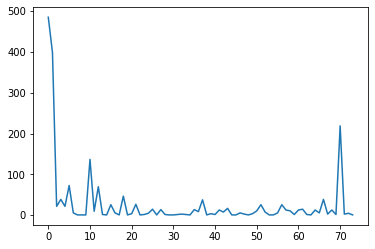

In [349]:
plt.plot(num_choices_list)

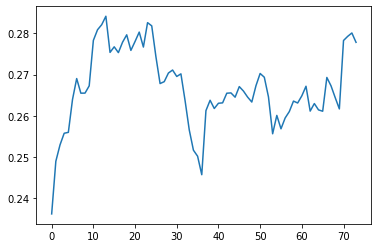

In [350]:
plt.plot(losses)

In [176]:
model.generate(tokenizer.encode("test"))

AttributeError: 'list' object has no attribute 'new_ones'

In [77]:
text = "Replace me by something useresfsf f sdf dsf dsfd fd f fd fdf"
encoded_input = tokenizer(text, return_tensors='pt').to(device)
output = model(**encoded_input)

In [78]:
len(output)

2

In [79]:
output[0].shape

torch.Size([1, 24, 50257])

In [83]:
len(output[1])

12

In [84]:
len(output[1][-1])

2

In [85]:
output[1][-1][1].shape

torch.Size([1, 12, 24, 64])

In [ ]:
# shape of output[1] is [12, 2,  1, 12, len(previous_tokens), 64]

In [38]:
output[1][0][0].shape

torch.Size([1, 12, 4, 64])

In [75]:
past[0][0].shape

torch.Size([1, 12, 101, 64])

In [86]:
12 * 2 * 12 * 64

18432

In [ ]:
for vec in past:
    for ten in vec:
        ten.requires_grad_(True)

In [ ]:
gen_tokens = model.generate(past_key_values=past, do_sample=True, temperature=0.9, max_length=100, use_cache=True)

In [ ]:
gen_text = tokenizer.batch_decode(gen_tokens)[0]
gen_text

In [ ]:
len(out)

In [ ]:
out[0].shape

In [ ]:
len(out[1])

In [ ]:
len(out[1][0])

In [ ]:
out[1][0][0].shape

In [ ]:
for step in range(opt_steps):
    text_feats = model.encode_text(opt_tokens.cuda())
    
    loss = -1 * torch.nn.functional.cosine_similarity(text_feats, img_feats)
    
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    print(opt_tokens)
